# IIAS Filesystem Storage Report
Query the IIAS database to summarize network traffic for your IIA System using the database collected and stored in the IIAS Database. The historical records for the IIAS System are stored in the IBM_SAILFISH Schema.

## Db2 Extensions
This tutorial relies on a Jupyter notebook extensions, commonly refer to as a "magic" commands. The beginning of all of the notebooks begin with the following command which will load the extension and allow the remainder of the notebook to use the %sql magic command.
<pre>
&#37;run db2.ipynb
</pre>
The cell below will load the Db2 extension. Note that it will take a few seconds for the extension to load, so you should generally wait until the "Db2 Extensions Loaded" message is displayed in your notebook. You can find out more about the Db2 Extensions at https://github.com/DB2-Samples/db2jupyter

In [1]:
%run db2.ipynb

Pixiedust database opened successfully


DB2 Extensions Loaded.


In [2]:
# load pandas for dataframe support and numpy for statistical manipulation and matplot for graphing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Connections to Db2

Before any SQL commands can be issued, a connection needs to be made to the Db2 database that you will be using. The connection can be done manually (through the use of the CONNECT command), or automatically when the first %sql command is issued.

The Db2 magic command tracks whether or not a connection has occured in the past and saves this information between notebooks and sessions. When you start up a notebook and issue a command, the program will reconnect to the database using your credentials from the last session. In the event that you have not connected before, the system will prompt you for all the information it needs to connect. This information includes:

- Database name (SAMPLE) 
- Hostname - localhost (enter an IP address if you need to connect to a remote server) 
- PORT - 50000 (this is the default but it could be different) 
- Userid - DB2INST1 
- Password - No password is provided so you have to enter a value 
- Maximum Rows - 10 lines of output are displayed when a result set is returned 

There will be default values presented in the panels that you can accept, or enter your own values. All of the information will be stored in the directory that the notebooks are stored on. Once you have entered the information, the system will attempt to connect to the database for you and then you can run all of the SQL scripts. More details on the CONNECT syntax will be found in a section below.

The next statement will force a CONNECT to occur with the default values. If you have not connected before, it will prompt you for the information.

In [ ]:
%sql connect reset

In [5]:
# create a persistent connection to the DSM Historical Repository Database
%sql connect to BLUDB user bluadmin using ? host sail62-t14.swg.usma.ibm.com port 50000

Password [password]: ········
Connection successful.


## Retrieving historical system data from IIAS

The [ADMINTABINFO administrative view](https://www.ibm.com/support/knowledgecenter/en/SSEPGG_11.1.0/com.ibm.db2.luw.sql.rtn.doc/doc/r0052897.html)
returns size and state information for tables, materialized query tables (MQT) and hierarchy tables only. These table types are reported as T for table, S for materialized query tables and H for hierarchy tables in the SYSCAT.TABLES catalog view. The information is returned at both the data partition level and the database partition level for a table.

The query below shows you all the System Level monitoring tables available.

In [6]:
%sql -a SELECT TABNAME AS SYSTEM_MONITORING_TABLES FROM SYSCAT.TABLES WHERE TABSCHEMA = 'IBM_SAILFISH' ORDER BY TABNAME

,SYSTEM_MONITORING_TABLES
0,ALERTS_MAPPING
1,MONITORING_CPU
2,MONITORING_IO_READ
3,MONITORING_IO_WRITE
4,MONITORING_MEMORY
5,MONITORING_NETWORK_RX
6,MONITORING_NETWORK_TX
7,MONITORING_STORAGE_FILESYSTEMS
8,MONITORING_STORAGE_NODELEVEL
9,MONITORING_STORAGE_NODES


## Retrieving Data and Converting Time
The current timestamps of the collected data is stored in UNIX EPOCH format, seconds since January 1st, 1970. To convert to more useful values the statement below retrieves the database from the warehouse database and constructs several columns that can be used to group and classify data later. The results are automatically streamed into a new Data Frame called NetworkTX.

In [12]:
FileSystemStorage = %sql \
SELECT \
    "NAME", \
    TIME(TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS TIME_COLLECTED, \
    HOUR(TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS HOUR_COLLECTED, \
    DATE(TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS DATE_COLLECTED, \
    (TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS TIMESTAMP_COLLECTED, \
    TS AS EPOCH_TIME, \
    "USED" AS USED_GB, \
    "CAPACITY" AS CAPACITY_GB \
    FROM "IBM_SAILFISH"."MONITORING_STORAGE_FILESYSTEMS"; 
FileSystemStorage.head()

,NAME,TIME_COLLECTED,HOUR_COLLECTED,DATE_COLLECTED,TIMESTAMP_COLLECTED,EPOCH_TIME,USED_GB,CAPACITY_GB
0,head ...,19:31:55,19,2018-05-29,2018-05-29 19:31:55,1527622315784,95.60,3072.00
1,data ...,19:31:55,19,2018-05-29,2018-05-29 19:31:55,1527622315784,13.49,115711.95
2,scratch ...,19:31:55,19,2018-05-29,2018-05-29 19:31:55,1527622315784,1867.25,15360.00
3,local ...,19:31:55,19,2018-05-29,2018-05-29 19:31:55,1527622315784,2294.17,115711.95
4,head ...,19:32:56,19,2018-05-29,2018-05-29 19:32:56,1527622376317,95.60,3072.00


## Creating a Pivot Table
With a simple single command you can use the existing dataframe to pivot the dataset by day and hour.

In [13]:
pd.pivot_table(FileSystemStorage,index=["DATE_COLLECTED","HOUR_COLLECTED","NAME"])

CAPACITY_GB  \
DATE_COLLECTED HOUR_COLLECTED NAME                                                              
2018-05-06     15             data                                                  115711.95   
                              head                                                    3072.00   
                              local                                                 115711.95   
                              scratch                                                15360.00   
               16             data                                                  115711.95   
...                                                                                       ...   
2018-06-04     21             scratch                                                15360.00   
               22             data                                                  115711.95   
                              head                                                    3072.00   
                              local                                                 115711.95   
                              scratch                                                15360.00   

                                                                                    EPOCH_TIME  \
DATE_COLLECTED HOUR_COLLECTED NAME                                                               
2018-05-06     15             data                                                1.525621e+12   
                              head                                                1.525621e+12   
                              local                                               1.525621e+12   
                              scratch                                             1.525621e+12   
               16             data                                                1.525624e+12   
...                                                                                        ...   
2018-06-04     21             scratch                                             1.528148e+12   
               22             data                                                1.528151e+12   
                              head                                                1.528151e+12   
                              local                                               1.528151e+12   
                              scratch                                             1.528151e+12   

                                                                                      USED_GB  
DATE_COLLECTED HOUR_COLLECTED NAME                                                             
2018-05-06     15             data                                                  10.444444  
                              head                                                  14.873333  
                              local                                               2294.090000  
                              scratch                                              120.600000  
               16             data                                                  10.620000  
...                                                                                       ...  
2018-06-04     21             scratch                                             1869.580000  
               22             data                                                  13.490000  
                              head                                                  95.899167  
                              local                                               2294.190000  
                              scratch                                             1869.580000  

[1360 rows x 3 columns]

## Graphing Receive and Transmit Volumes
So see the full dataset more easily you can graph both send and receive volumns.

In [28]:
FileSystemStorageData = %sql \
SELECT \
    "NAME", \
    TIME(TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS TIME_COLLECTED, \
    HOUR(TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS HOUR_COLLECTED, \
    DATE(TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS DATE_COLLECTED, \
    (TIMESTAMP('1970-01-01','00.00.00') + (TS/1000) SECOND) AS TIMESTAMP_COLLECTED, \
    TS AS EPOCH_TIME, \
    "USED" AS USED_GB, \
    "CAPACITY" AS CAPACITY_GB \
    FROM "IBM_SAILFISH"."MONITORING_STORAGE_FILESYSTEMS" WHERE NAME = 'data'; 
FileSystemStorageData.head()

,NAME,TIME_COLLECTED,HOUR_COLLECTED,DATE_COLLECTED,TIMESTAMP_COLLECTED,EPOCH_TIME,USED_GB,CAPACITY_GB
0,data ...,04:48:06,4,2018-05-27,2018-05-27 04:48:06,1527396486859,13.49,115711.95
1,data ...,04:49:06,4,2018-05-27,2018-05-27 04:49:06,1527396546973,13.49,115711.95
2,data ...,04:50:07,4,2018-05-27,2018-05-27 04:50:07,1527396607422,13.49,115711.95
3,data ...,04:51:07,4,2018-05-27,2018-05-27 04:51:07,1527396667473,13.49,115711.95
4,data ...,04:52:07,4,2018-05-27,2018-05-27 04:52:07,1527396727553,13.49,115711.95


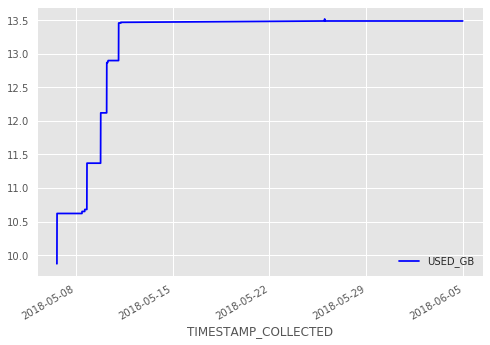

In [29]:
FileSystemStorageData.sort_values('EPOCH_TIME').plot(x='TIMESTAMP_COLLECTED', y='USED_GB', color='b')
plt.show()